
Fit coefficients in astronomical units:
c_-1 (slope) = 3.98e+09 M_sun/kpc
c_0 (intercept) = -8.55e+08 M_sun
Radius beyond which M(r) > 0 : 6.63e+18 m (0.21 kpc)
R-squared: 0.9803
Adjusted R-squared: 0.9789
RMSE entre velocidad observacional y teórica: 6.32 km/s


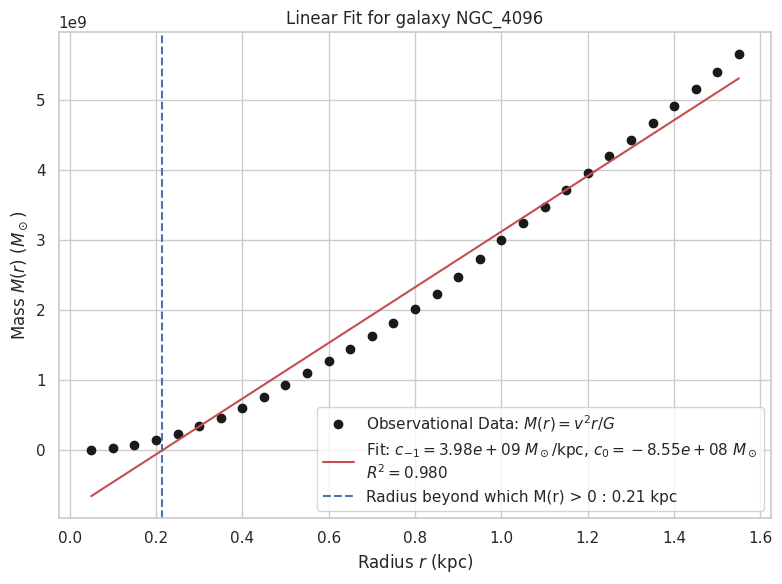

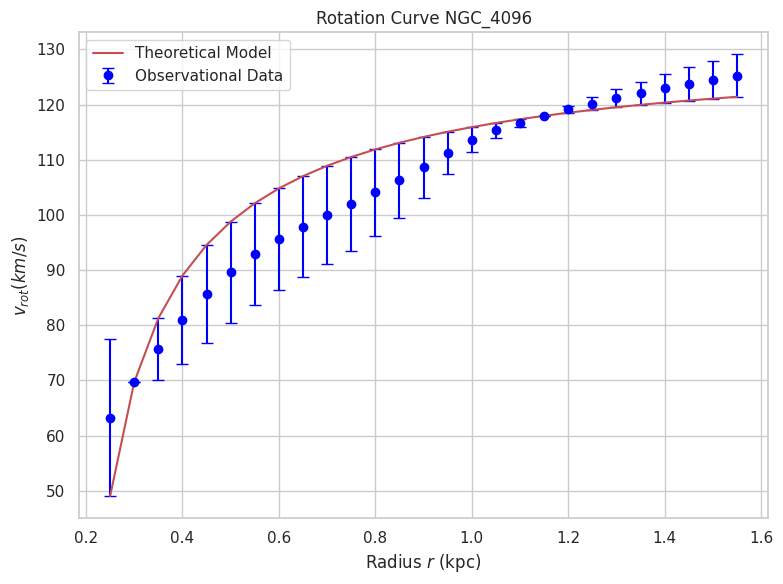

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import curve_fit

# Diccionario completo de galaxias
galaxies = {
    1: 'NGC_6674',
    2: 'NGC_224',
    3: 'NGC_100',
    4: 'NGC_1705',
    5: 'NGC_3198',
    6: 'NGC_3672',
    7: 'UGC_3691',
    8: 'NGC_4321',
    9: 'NGC_4565',
    10: 'NGC_5055',
    11: 'NGC_5907',
    12: 'NGC_7331',
    13: 'NGC_6951',
    14: 'IC_342',
    15: 'NGC_1003',
    16: 'NGC_2403',
    17: 'NGC_4062',
    18: 'NGC_4096',
    19: 'NGC_4631',
    20: 'DDO_170',
    21: 'ESO_444_C084',
    22: 'F563_1',
    23: 'F571_8',
    24: 'NGC_55',
    25: 'NGC_3972',
    26: 'NGC_4214',
    27: 'NGC_4271',
    28: 'NGC_4559',
    29: 'UGC_731',
    30: 'UGC_5986',
    31: 'UGC_6786',
    32: 'UGC_6983',
    33: 'UGC_7524',
    34: 'UGC_7603',
    35: 'UGC_8286',
    36: 'UGC_8490',
    37: 'UGC_11455',
    38: 'UGC_11914',
    39: 'UGC_12506',
    40: 'UGC_12632',
    41: 'UGC_12732',
    42: 'UGC_A444',
    43: 'UGC_8490',
    44: 'NGC_3031',
    45: 'Milky_Way'
}

# Selección de galaxia
selected_galaxy = 18
galaxy_name = galaxies.get(selected_galaxy, f"Unknown Galaxy {selected_galaxy}")
plot_id = f"{selected_galaxy:02d}"

# Datos observacionales
data_str = """
0.05000    17.25000
     0.10000    32.93750
     0.15000    45.50000
     0.20000    55.43750
     0.25000    63.25000
     0.30000    69.71875
     0.35000    75.62500
     0.40000    80.93750
     0.45000    85.62500
     0.50000    89.62500
     0.55000    92.87500
     0.60000    95.56250
     0.65000    97.87500
     0.70000    99.96875
     0.75000   102.00000
     0.80000   104.06250
     0.85000   106.25000
     0.90000   108.62500
     0.95000   111.25000
     1.00000   113.64063
     1.05000   115.31250
     1.10000   116.62500
     1.15000   117.93750
     1.20000   119.15625
     1.25000   120.18750
     1.30000   121.12500
     1.35000   122.06250
     1.40000   122.95313
     1.45000   123.75000
     1.50000   124.50000
     1.55000   125.25000
"""

# Cargar datos
data = np.array([[float(x) for x in line.split()] for line in data_str.strip().split('\n')])
r_kpc, v_kms = data[:, 0], data[:, 1]

# Conversiones de unidades
kpc_to_m = 3.086e19
km_to_m = 1e3
Msun_to_kg = 1.98847e30
G = constants.G

r = r_kpc * kpc_to_m
v = v_kms * km_to_m
valid_mask = (r > 0) & (v >= 0)

# Calcular masa M = v^2 r / G
M = np.zeros_like(r)
M[valid_mask] = (v[valid_mask]**2 * r[valid_mask]) / G

# Normalización para ajustar
r_norm = r / 1e20
M_norm = M / 1e40

# Modelo lineal
def linear_model(r, A, B):
    return A * r + B

try:
    popt, _ = curve_fit(linear_model, r_norm[valid_mask], M_norm[valid_mask])
    A_norm, B_norm = popt
    A = A_norm * 1e40 / 1e20
    B = B_norm * 1e40

    # Evaluación del ajuste
    M_pred = linear_model(r_norm[valid_mask], *popt)
    M_obs = M_norm[valid_mask]
    ss_res = np.sum((M_obs - M_pred) ** 2)
    ss_tot = np.sum((M_obs - np.mean(M_obs)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n, p = len(M_obs), 2
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    # Coeficientes en unidades astronómicas
    A_Msun_per_kpc = A * (kpc_to_m / Msun_to_kg)
    B_Msun = B / Msun_to_kg
    char_length = abs(B) / A if A != 0 else np.inf

    print("\nFit coefficients in astronomical units:")
    print(f"c_-1 (slope) = {A_Msun_per_kpc:.2e} M_sun/kpc")
    print(f"c_0 (intercept) = {B_Msun:.2e} M_sun")
    print(f"Radius beyond which M(r) > 0 : {char_length:.2e} m ({char_length/kpc_to_m:.2f} kpc)")
    print(f"R-squared: {r_squared:.4f}")
    print(f"Adjusted R-squared: {adj_r_squared:.4f}")

except Exception as e:
    print(f"Curve fitting failed: {e}")
    A = B = A_Msun_per_kpc = B_Msun = char_length = r_squared = adj_r_squared = np.nan

# Calcular densidad observacional
rho_obser = np.full_like(r, np.nan)
if not np.isnan(B):
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = v**2 / (r**2 * G)
        term2 = B / r**3
        rho_obser = (1/(4*np.pi)) * (term1 - term2)
        rho_obser[~valid_mask] = np.nan

# Velocidad teórica
v_rot_theo = np.full_like(r_kpc, np.nan)
if not np.isnan(A) and not np.isnan(B) and A != 0:
    mask = (r >= abs(B)/A) & valid_mask
    v_rot_theo[mask] = np.sqrt(G * (A * r[mask] + B) / r[mask]) / 1e3  # km/s

# Calcular RMSE entre velocidad observacional y teórica (donde válida)
rmse = np.nan
if not np.isnan(v_rot_theo).all():
    mask_rmse = ~np.isnan(v_rot_theo) & valid_mask
    if np.any(mask_rmse):
        rmse = np.sqrt(np.mean((v_kms[mask_rmse] - v_rot_theo[mask_rmse])**2))
        print(f"RMSE entre velocidad observacional y teórica: {rmse:.2f} km/s")

# Gráfico 1: Masa vs Radio
plt.figure(figsize=(8, 6))
plt.plot(r_kpc[valid_mask], M[valid_mask]/Msun_to_kg, 'ko', label='Observational Data: $M(r) = v^2 r / G$')
if not np.isnan(A):
    plt.plot(r_kpc, linear_model(r_norm, *popt) * 1e40 / Msun_to_kg, 'r-', label=(
        f'Fit: $c_{{-1}} = {A_Msun_per_kpc:.2e}$ $M_\\odot$/kpc, '
        f'$c_0 = {B_Msun:.2e}$ $M_\\odot$\n$R^2 = {r_squared:.3f}$'))
    plt.axvline(x=char_length/kpc_to_m, color='b', linestyle='--',
                label=f'Radius beyond which M(r) > 0 : {char_length/kpc_to_m:.2f} kpc')

plt.xlabel("Radius $r$ (kpc)")
plt.ylabel("Mass $M(r)$ ($M_\\odot$)")
plt.title(f"Linear Fit for galaxy {galaxy_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'mass_vs_radius_linear_{plot_id}_{galaxy_name.replace(" ", "_")}.png', dpi=300)
plt.show()

# Gráfico 2: Curva de velocidad teórica vs observacional con barras de error del modelo
if not np.isnan(v_rot_theo).all():
    mask_plot = ~np.isnan(v_rot_theo) & valid_mask

    # Error absoluto entre datos observacionales y modelo teórico
    error_model = np.abs(v_kms[mask_plot] - v_rot_theo[mask_plot])

    plt.figure(figsize=(8, 6))
    plt.errorbar(r_kpc[mask_plot], v_kms[mask_plot], yerr=error_model, fmt='o', label='Observational Data', color='blue', capsize=4)
    plt.plot(r_kpc[mask_plot], v_rot_theo[mask_plot], 'r-', label='Theoretical Model')
    plt.xlabel("Radius $r$ (kpc)")
    plt.ylabel(f"$v_{{rot}} (km/s)$")
    plt.title(f"Rotation Curve {galaxy_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'rotation_curve_linear_{plot_id}_{galaxy_name.replace(" ", "_")}.png', dpi=300)
    plt.show()